In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_conv_5_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 9):
    model = build_1d_cnn_only_conv_conv_5_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15996, 8)          48        
_________________________________________________________________
activation (Activation)      (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5332, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 42656)             0         
_________________________________________________________________
dropout (Dropout)            (None, 42656)             0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
activation_15 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
activation_16 (Activation)   (None, 5328, 16)          0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1776, 16)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1772, 32)          2592      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5786 - acc: 0.1698
Epoch 00001: val_loss improved from inf to 2.45625, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_1_conv_checkpoint/001-2.4563.hdf5
36805/36805 [==============================] - 8s 216us/sample - loss: 2.5785 - acc: 0.1699 - val_loss: 2.4563 - val_acc: 0.2176
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3829 - acc: 0.2533
Epoch 00002: val_loss improved from 2.45625 to 2.37448, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_1_conv_checkpoint/002-2.3745.hdf5
36805/36805 [==============================] - 6s 166us/sample - loss: 2.3830 - acc: 0.2533 - val_loss: 2.3745 - val_acc: 0.2539
Epoch 3/500
36544/36805 [============================>.] - ETA: 0s - loss: 2.2653 - acc: 0.3031
Epoch 00003: val_loss improved from 2.37448 to 2.31661, savin

Epoch 26/500
36544/36805 [============================>.] - ETA: 0s - loss: 1.4113 - acc: 0.5646
Epoch 00026: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 162us/sample - loss: 1.4116 - acc: 0.5642 - val_loss: 2.2617 - val_acc: 0.3205
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3890 - acc: 0.5731
Epoch 00027: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 165us/sample - loss: 1.3887 - acc: 0.5732 - val_loss: 2.2691 - val_acc: 0.3196
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3749 - acc: 0.5769
Epoch 00028: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 160us/sample - loss: 1.3750 - acc: 0.5768 - val_loss: 2.2637 - val_acc: 0.3215
Epoch 29/500
36544/36805 [============================>.] - ETA: 0s - loss: 1.3586 - acc: 0.5823
Epoch 00029: val_loss did not improve from 2.21459
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1211 - acc: 0.6500
Epoch 00056: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 165us/sample - loss: 1.1211 - acc: 0.6500 - val_loss: 2.3565 - val_acc: 0.3375
Epoch 57/500
36544/36805 [============================>.] - ETA: 0s - loss: 1.1200 - acc: 0.6482
Epoch 00057: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 161us/sample - loss: 1.1207 - acc: 0.6478 - val_loss: 2.3723 - val_acc: 0.3331
Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.1143 - acc: 0.6522
Epoch 00058: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 165us/sample - loss: 1.1150 - acc: 0.6521 - val_loss: 2.3726 - val_acc: 0.3322
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1032 - acc: 0.6530
Epoch 00059: val_loss did not improve from 2.21459
36805/36805 [========

Epoch 86/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9673 - acc: 0.6950
Epoch 00086: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 169us/sample - loss: 0.9665 - acc: 0.6953 - val_loss: 2.4724 - val_acc: 0.3440
Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9616 - acc: 0.6948
Epoch 00087: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 163us/sample - loss: 0.9616 - acc: 0.6949 - val_loss: 2.4635 - val_acc: 0.3468
Epoch 88/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9676 - acc: 0.6935
Epoch 00088: val_loss did not improve from 2.21459
36805/36805 [==============================] - 6s 164us/sample - loss: 0.9676 - acc: 0.6936 - val_loss: 2.4729 - val_acc: 0.3487
Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9563 - acc: 0.6985
Epoch 00089: val_loss did not improve from 2.21459
36805/36805 [========

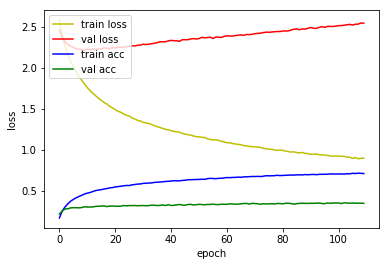

4815/4815 [==============================] - 1s 140us/sample - loss: 2.2452 - acc: 0.2818
Loss: 2.2452293619807513 Accuracy: 0.28182763

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36672/36805 [============================>.] - ETA: 0s - loss: 2.5109 - acc: 0.2158
Epoch 00001: val_loss improved from inf to 2.29192, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_2_conv_checkpoint/001-2.2919.hdf5
36805/36805 [==============================] - 9s 235us/sample - loss: 2.5101 - acc: 0.2162 - val_loss: 2.2919 - val_acc: 0.3091
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1601 - acc: 0.3418
Epoch 00002: val_loss improved from 2.29192 to 2.06798, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_2_conv_checkpoint/002-2.0680.hdf5
36805/36805 [==============================] - 8s 219us/sample - loss: 2.1600 - acc: 0.3419 - val_loss: 2.0680 - val_acc: 0.3790
Epoch 3/500
36544/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.1515 - acc: 0.6368
Epoch 00024: val_loss did not improve from 1.66728
36805/36805 [==============================] - 8s 218us/sample - loss: 1.1518 - acc: 0.6368 - val_loss: 1.6732 - val_acc: 0.4864
Epoch 25/500
36608/36805 [============================>.] - ETA: 0s - loss: 1.1365 - acc: 0.6426
Epoch 00025: val_loss improved from 1.66728 to 1.66179, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_2_conv_checkpoint/025-1.6618.hdf5
36805/36805 [==============================] - 8s 220us/sample - loss: 1.1381 - acc: 0.6424 - val_loss: 1.6618 - val_acc: 0.4908
Epoch 26/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.1229 - acc: 0.6460
Epoch 00026: val_loss did not improve from 1.66179
36805/36805 [==============================] - 8s 219us/sample - loss: 1.1227 - acc: 0.6460 - val_loss: 1.6655 - val_acc: 0.4854
Epoch 27/500
36608/36805 [============================>.] - ETA: 0s - 

Epoch 82/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6895 - acc: 0.7772
Epoch 00082: val_loss did not improve from 1.65082
36805/36805 [==============================] - 8s 205us/sample - loss: 0.6896 - acc: 0.7770 - val_loss: 1.7146 - val_acc: 0.5297
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6832 - acc: 0.7764
Epoch 00083: val_loss did not improve from 1.65082
36805/36805 [==============================] - 8s 208us/sample - loss: 0.6835 - acc: 0.7763 - val_loss: 1.7174 - val_acc: 0.5346
Epoch 84/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6782 - acc: 0.7812
Epoch 00084: val_loss did not improve from 1.65082
36805/36805 [==============================] - 8s 206us/sample - loss: 0.6785 - acc: 0.7812 - val_loss: 1.7227 - val_acc: 0.5411
Epoch 85/500
36544/36805 [============================>.] - ETA: 0s - loss: 0.6732 - acc: 0.7838
Epoch 00085: val_loss did not improve from 1.65082
36805/36805 [========

Epoch 112/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5746 - acc: 0.8113
Epoch 00112: val_loss did not improve from 1.65082
36805/36805 [==============================] - 8s 213us/sample - loss: 0.5744 - acc: 0.8114 - val_loss: 1.7531 - val_acc: 0.5490
Epoch 113/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5667 - acc: 0.8145
Epoch 00113: val_loss did not improve from 1.65082
36805/36805 [==============================] - 8s 214us/sample - loss: 0.5659 - acc: 0.8148 - val_loss: 1.7565 - val_acc: 0.5488
Epoch 114/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5651 - acc: 0.8134
Epoch 00114: val_loss did not improve from 1.65082
36805/36805 [==============================] - 8s 218us/sample - loss: 0.5648 - acc: 0.8136 - val_loss: 1.7606 - val_acc: 0.5504
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5624 - acc: 0.8160
Epoch 00115: val_loss did not improve from 1.65082
36805/36805 [====

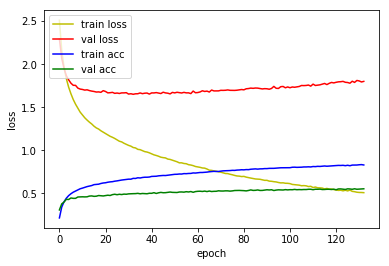

4815/4815 [==============================] - 1s 159us/sample - loss: 1.7158 - acc: 0.4671
Loss: 1.7157914078000427 Accuracy: 0.46708202

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36672/36805 [============================>.] - ETA: 0s - loss: 2.4930 - acc: 0.2115
Epoch 00001: val_loss improved from inf to 2.16232, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_3_conv_checkpoint/001-2.1623.hdf5
36805/36805 [==============================] - 10s 278us/sample - loss: 2.4921 - acc: 0.2119 - val_loss: 2.1623 - val_acc: 0.3471
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9921 - acc: 0.3825
Epoch 00002: val_loss improved from 2.16232 to 1.79949, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_3_conv_checkpoint/002-1.7995.hdf5
36805/36805 [==============================] - 9s 248us/sample - loss: 1.9921 - acc: 0.3825 - val_loss: 1.7995 - val_acc: 0.4545
Epoch 3/500
36608/36805 [============================>.] - ETA: 0s 

Epoch 24/500
36608/36805 [============================>.] - ETA: 0s - loss: 1.0147 - acc: 0.6922
Epoch 00024: val_loss improved from 1.23483 to 1.23414, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_3_conv_checkpoint/024-1.2341.hdf5
36805/36805 [==============================] - 9s 250us/sample - loss: 1.0138 - acc: 0.6924 - val_loss: 1.2341 - val_acc: 0.6161
Epoch 25/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9973 - acc: 0.6964
Epoch 00025: val_loss improved from 1.23414 to 1.22667, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_3_conv_checkpoint/025-1.2267.hdf5
36805/36805 [==============================] - 9s 252us/sample - loss: 0.9973 - acc: 0.6964 - val_loss: 1.2267 - val_acc: 0.6173
Epoch 26/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9834 - acc: 0.7024
Epoch 00026: val_loss improved from 1.22667 to 1.22293, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_3_conv_checkpoint/026-1.2229.hdf5
3

Epoch 49/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7104 - acc: 0.7814
Epoch 00049: val_loss improved from 1.16911 to 1.16273, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_3_conv_checkpoint/049-1.1627.hdf5
36805/36805 [==============================] - 9s 245us/sample - loss: 0.7106 - acc: 0.7811 - val_loss: 1.1627 - val_acc: 0.6445
Epoch 50/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.6968 - acc: 0.7829
Epoch 00050: val_loss did not improve from 1.16273
36805/36805 [==============================] - 9s 247us/sample - loss: 0.6972 - acc: 0.7827 - val_loss: 1.1836 - val_acc: 0.6448
Epoch 51/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6916 - acc: 0.7839
Epoch 00051: val_loss did not improve from 1.16273
36805/36805 [==============================] - 9s 248us/sample - loss: 0.6915 - acc: 0.7840 - val_loss: 1.1709 - val_acc: 0.6452
Epoch 52/500
36608/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4011 - acc: 0.8701
Epoch 00106: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 243us/sample - loss: 0.4011 - acc: 0.8701 - val_loss: 1.1834 - val_acc: 0.6865
Epoch 107/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3971 - acc: 0.8720
Epoch 00107: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 251us/sample - loss: 0.3975 - acc: 0.8717 - val_loss: 1.2082 - val_acc: 0.6832
Epoch 108/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3903 - acc: 0.8740
Epoch 00108: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 239us/sample - loss: 0.3906 - acc: 0.8738 - val_loss: 1.1924 - val_acc: 0.6837
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3917 - acc: 0.8728
Epoch 00109: val_loss did not improve from 1.15818
36805/36805 [==================

Epoch 136/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3261 - acc: 0.8930
Epoch 00136: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 242us/sample - loss: 0.3268 - acc: 0.8928 - val_loss: 1.2365 - val_acc: 0.6904
Epoch 137/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3251 - acc: 0.8925
Epoch 00137: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 243us/sample - loss: 0.3251 - acc: 0.8925 - val_loss: 1.2296 - val_acc: 0.6969
Epoch 138/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.8948
Epoch 00138: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 243us/sample - loss: 0.3240 - acc: 0.8948 - val_loss: 1.2291 - val_acc: 0.6909
Epoch 139/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3175 - acc: 0.8973
Epoch 00139: val_loss did not improve from 1.15818
36805/36805 [====

Epoch 166/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2740 - acc: 0.9110
Epoch 00166: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 244us/sample - loss: 0.2745 - acc: 0.9110 - val_loss: 1.2684 - val_acc: 0.7000
Epoch 167/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.9075
Epoch 00167: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 241us/sample - loss: 0.2725 - acc: 0.9075 - val_loss: 1.2554 - val_acc: 0.7032
Epoch 168/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.2691 - acc: 0.9106
Epoch 00168: val_loss did not improve from 1.15818
36805/36805 [==============================] - 9s 249us/sample - loss: 0.2688 - acc: 0.9107 - val_loss: 1.2635 - val_acc: 0.7018
Epoch 169/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2660 - acc: 0.9137
Epoch 00169: val_loss did not improve from 1.15818
36805/36805 [====

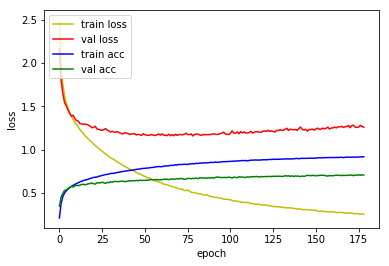

4815/4815 [==============================] - 1s 189us/sample - loss: 1.2891 - acc: 0.6295
Loss: 1.2891465662672017 Accuracy: 0.62949115

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36672/36805 [============================>.] - ETA: 0s - loss: 2.4013 - acc: 0.2305
Epoch 00001: val_loss improved from inf to 1.90511, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/001-1.9051.hdf5
36805/36805 [==============================] - 12s 316us/sample - loss: 2.3995 - acc: 0.2312 - val_loss: 1.9051 - val_acc: 0.3911
Epoch 2/500
36608/36805 [============================>.] - ETA: 0s - loss: 1.7878 - acc: 0.4294
Epoch 00002: val_loss improved from 1.90511 to 1.63356, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/002-1.6336.hdf5
36805/36805 [==============================] - 10s 265us/sample - loss: 1.7881 - acc: 0.4291 - val_loss: 1.6336 - val_acc: 0.4945
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s

Epoch 23/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.8554 - acc: 0.7410
Epoch 00023: val_loss improved from 0.95866 to 0.93443, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/023-0.9344.hdf5
36805/36805 [==============================] - 10s 265us/sample - loss: 0.8552 - acc: 0.7410 - val_loss: 0.9344 - val_acc: 0.7244
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8360 - acc: 0.7463
Epoch 00024: val_loss improved from 0.93443 to 0.92387, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/024-0.9239.hdf5
36805/36805 [==============================] - 10s 266us/sample - loss: 0.8360 - acc: 0.7463 - val_loss: 0.9239 - val_acc: 0.7298
Epoch 25/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8211 - acc: 0.7509
Epoch 00025: val_loss did not improve from 0.92387
36805/36805 [==============================] - 10s 261us/sample - loss: 0.8209 - acc: 0.7511 - val

Epoch 48/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5385 - acc: 0.8334
Epoch 00048: val_loss improved from 0.81040 to 0.80929, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/048-0.8093.hdf5
36805/36805 [==============================] - 10s 269us/sample - loss: 0.5384 - acc: 0.8334 - val_loss: 0.8093 - val_acc: 0.7610
Epoch 49/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5276 - acc: 0.8379
Epoch 00049: val_loss improved from 0.80929 to 0.80254, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/049-0.8025.hdf5
36805/36805 [==============================] - 10s 264us/sample - loss: 0.5277 - acc: 0.8380 - val_loss: 0.8025 - val_acc: 0.7710
Epoch 50/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5194 - acc: 0.8406
Epoch 00050: val_loss improved from 0.80254 to 0.79824, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_4_conv_checkpoint/050-0.7982.hdf5

Epoch 75/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3695 - acc: 0.8818
Epoch 00075: val_loss did not improve from 0.77799
36805/36805 [==============================] - 9s 258us/sample - loss: 0.3698 - acc: 0.8817 - val_loss: 0.8017 - val_acc: 0.7829
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3641 - acc: 0.8849
Epoch 00076: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 263us/sample - loss: 0.3643 - acc: 0.8847 - val_loss: 0.8006 - val_acc: 0.7845
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3564 - acc: 0.8868
Epoch 00077: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 263us/sample - loss: 0.3564 - acc: 0.8868 - val_loss: 0.7957 - val_acc: 0.7838
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3515 - acc: 0.8886
Epoch 00078: val_loss did not improve from 0.77799
36805/36805 [======

Epoch 105/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2664 - acc: 0.9138
Epoch 00105: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 264us/sample - loss: 0.2665 - acc: 0.9138 - val_loss: 0.8364 - val_acc: 0.7845
Epoch 106/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2657 - acc: 0.9131
Epoch 00106: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 262us/sample - loss: 0.2655 - acc: 0.9132 - val_loss: 0.8255 - val_acc: 0.7908
Epoch 107/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2606 - acc: 0.9155
Epoch 00107: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 259us/sample - loss: 0.2605 - acc: 0.9156 - val_loss: 0.8274 - val_acc: 0.7897
Epoch 108/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2611 - acc: 0.9155
Epoch 00108: val_loss did not improve from 0.77799
36805/36805 [=

Epoch 135/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2132 - acc: 0.9308
Epoch 00135: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 265us/sample - loss: 0.2130 - acc: 0.9309 - val_loss: 0.8537 - val_acc: 0.7890
Epoch 136/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2122 - acc: 0.9306
Epoch 00136: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 263us/sample - loss: 0.2121 - acc: 0.9306 - val_loss: 0.8557 - val_acc: 0.7929
Epoch 137/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.2095 - acc: 0.9313
Epoch 00137: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 260us/sample - loss: 0.2097 - acc: 0.9313 - val_loss: 0.8401 - val_acc: 0.8008
Epoch 138/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.2113 - acc: 0.9304
Epoch 00138: val_loss did not improve from 0.77799
36805/36805 [=

Epoch 165/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1763 - acc: 0.9416
Epoch 00165: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 262us/sample - loss: 0.1764 - acc: 0.9414 - val_loss: 0.8669 - val_acc: 0.7994
Epoch 166/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1761 - acc: 0.9420
Epoch 00166: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 262us/sample - loss: 0.1761 - acc: 0.9420 - val_loss: 0.8783 - val_acc: 0.8032
Epoch 167/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1802 - acc: 0.9401
Epoch 00167: val_loss did not improve from 0.77799
36805/36805 [==============================] - 10s 262us/sample - loss: 0.1801 - acc: 0.9401 - val_loss: 0.8570 - val_acc: 0.8034

1D_CNN_only_conv_conv_5_DO_4_conv Model


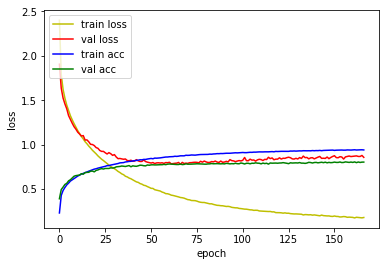

4815/4815 [==============================] - 1s 208us/sample - loss: 0.8589 - acc: 0.7556
Loss: 0.8589462688778791 Accuracy: 0.75555557

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4454 - acc: 0.2027
Epoch 00001: val_loss improved from inf to 1.93947, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_5_conv_checkpoint/001-1.9395.hdf5
36805/36805 [==============================] - 13s 351us/sample - loss: 2.4447 - acc: 0.2030 - val_loss: 1.9395 - val_acc: 0.3753
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8154 - acc: 0.4173
Epoch 00002: val_loss improved from 1.93947 to 1.65142, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_5_conv_checkpoint/002-1.6514.hdf5
36805/36805 [==============================] - 11s 285us/sample - loss: 1.8155 - acc: 0.4173 - val_loss: 1.6514 - val_acc: 0.4934
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7606 - acc: 0.7710
Epoch 00023: val_loss did not improve from 0.76580
36805/36805 [==============================] - 10s 278us/sample - loss: 0.7607 - acc: 0.7710 - val_loss: 0.7857 - val_acc: 0.7692
Epoch 24/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7358 - acc: 0.7768
Epoch 00024: val_loss improved from 0.76580 to 0.73132, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_5_conv_checkpoint/024-0.7313.hdf5
36805/36805 [==============================] - 10s 283us/sample - loss: 0.7362 - acc: 0.7767 - val_loss: 0.7313 - val_acc: 0.7918
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7197 - acc: 0.7836
Epoch 00025: val_loss improved from 0.73132 to 0.71210, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_5_conv_checkpoint/025-0.7121.hdf5
36805/36805 [==============================] - 11s 287us/sample - loss: 0.7195 - acc: 0.7836 - val

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.9054
Epoch 00073: val_loss did not improve from 0.47449
36805/36805 [==============================] - 10s 279us/sample - loss: 0.3016 - acc: 0.9054 - val_loss: 0.4980 - val_acc: 0.8658
Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2924 - acc: 0.9086
Epoch 00074: val_loss improved from 0.47449 to 0.47301, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_5_conv_checkpoint/074-0.4730.hdf5
36805/36805 [==============================] - 10s 284us/sample - loss: 0.2924 - acc: 0.9086 - val_loss: 0.4730 - val_acc: 0.8703
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2912 - acc: 0.9086
Epoch 00075: val_loss improved from 0.47301 to 0.46863, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_5_conv_checkpoint/075-0.4686.hdf5
36805/36805 [==============================] - 10s 282us/sample - loss: 0.2912 - acc: 0.9085 - val

36672/36805 [============================>.] - ETA: 0s - loss: 0.2201 - acc: 0.9285
Epoch 00101: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 282us/sample - loss: 0.2198 - acc: 0.9287 - val_loss: 0.4911 - val_acc: 0.8789
Epoch 102/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2150 - acc: 0.9300
Epoch 00102: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 283us/sample - loss: 0.2154 - acc: 0.9297 - val_loss: 0.4743 - val_acc: 0.8828
Epoch 103/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2120 - acc: 0.9302
Epoch 00103: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 279us/sample - loss: 0.2119 - acc: 0.9302 - val_loss: 0.4690 - val_acc: 0.8856
Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9321
Epoch 00104: val_loss did not improve from 0.45422
36805/36805 [===============

Epoch 131/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1649 - acc: 0.9455
Epoch 00131: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 279us/sample - loss: 0.1647 - acc: 0.9456 - val_loss: 0.4946 - val_acc: 0.8873
Epoch 132/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9451
Epoch 00132: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 280us/sample - loss: 0.1651 - acc: 0.9451 - val_loss: 0.4960 - val_acc: 0.8849
Epoch 133/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1611 - acc: 0.9485
Epoch 00133: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 280us/sample - loss: 0.1612 - acc: 0.9485 - val_loss: 0.4953 - val_acc: 0.8891
Epoch 134/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1608 - acc: 0.9474
Epoch 00134: val_loss did not improve from 0.45422
36805/36805 [=

Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1343 - acc: 0.9561
Epoch 00161: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 282us/sample - loss: 0.1343 - acc: 0.9561 - val_loss: 0.5229 - val_acc: 0.8847
Epoch 162/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1308 - acc: 0.9567
Epoch 00162: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 281us/sample - loss: 0.1309 - acc: 0.9566 - val_loss: 0.4999 - val_acc: 0.8898
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9561
Epoch 00163: val_loss did not improve from 0.45422
36805/36805 [==============================] - 10s 284us/sample - loss: 0.1316 - acc: 0.9561 - val_loss: 0.5158 - val_acc: 0.8905
Epoch 164/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1322 - acc: 0.9575
Epoch 00164: val_loss did not improve from 0.45422
36805/36805 [=

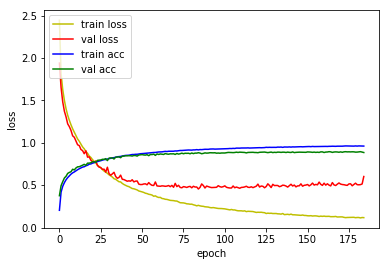

4815/4815 [==============================] - 1s 237us/sample - loss: 0.5174 - acc: 0.8492
Loss: 0.5174186083015252 Accuracy: 0.84922117

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3144 - acc: 0.2407
Epoch 00001: val_loss improved from inf to 1.75361, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_6_conv_checkpoint/001-1.7536.hdf5
36805/36805 [==============================] - 14s 377us/sample - loss: 2.3133 - acc: 0.2412 - val_loss: 1.7536 - val_acc: 0.4354
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6448 - acc: 0.4697
Epoch 00002: val_loss improved from 1.75361 to 1.40416, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_6_conv_checkpoint/002-1.4042.hdf5
36805/36805 [==============================] - 12s 313us/sample - loss: 1.6448 - acc: 0.4696 - val_loss: 1.4042 - val_acc: 0.5660
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s

Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3869 - acc: 0.8799
Epoch 00023: val_loss did not improve from 0.36408
36805/36805 [==============================] - 11s 308us/sample - loss: 0.3869 - acc: 0.8800 - val_loss: 0.3734 - val_acc: 0.8896
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3700 - acc: 0.8849
Epoch 00024: val_loss improved from 0.36408 to 0.34741, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_6_conv_checkpoint/024-0.3474.hdf5
36805/36805 [==============================] - 11s 309us/sample - loss: 0.3703 - acc: 0.8847 - val_loss: 0.3474 - val_acc: 0.8998
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3612 - acc: 0.8882
Epoch 00025: val_loss improved from 0.34741 to 0.33925, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_6_conv_checkpoint/025-0.3392.hdf5
36805/36805 [==============================] - 11s 309us/sample - loss: 0.3614 - acc: 0.8882 - val

Epoch 48/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2143 - acc: 0.9300
Epoch 00048: val_loss did not improve from 0.27029
36805/36805 [==============================] - 11s 306us/sample - loss: 0.2143 - acc: 0.9299 - val_loss: 0.2995 - val_acc: 0.9113
Epoch 49/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2115 - acc: 0.9320
Epoch 00049: val_loss did not improve from 0.27029
36805/36805 [==============================] - 11s 312us/sample - loss: 0.2114 - acc: 0.9320 - val_loss: 0.2717 - val_acc: 0.9229
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9294
Epoch 00050: val_loss did not improve from 0.27029
36805/36805 [==============================] - 11s 311us/sample - loss: 0.2146 - acc: 0.9294 - val_loss: 0.2730 - val_acc: 0.9280
Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2050 - acc: 0.9334
Epoch 00051: val_loss improved from 0.27029 to 0.26447, saving model 

Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9652
Epoch 00104: val_loss did not improve from 0.24208
36805/36805 [==============================] - 11s 309us/sample - loss: 0.1008 - acc: 0.9653 - val_loss: 0.2530 - val_acc: 0.9343
Epoch 105/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9664
Epoch 00105: val_loss did not improve from 0.24208
36805/36805 [==============================] - 11s 303us/sample - loss: 0.0974 - acc: 0.9665 - val_loss: 0.2544 - val_acc: 0.9385
Epoch 106/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9679
Epoch 00106: val_loss did not improve from 0.24208
36805/36805 [==============================] - 11s 308us/sample - loss: 0.0938 - acc: 0.9679 - val_loss: 0.2645 - val_acc: 0.9387
Epoch 107/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0941 - acc: 0.9679
Epoch 00107: val_loss did not improve from 0.24208
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9737
Epoch 00133: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 307us/sample - loss: 0.0760 - acc: 0.9737 - val_loss: 0.2686 - val_acc: 0.9373
Epoch 134/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9766
Epoch 00134: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 307us/sample - loss: 0.0702 - acc: 0.9766 - val_loss: 0.2585 - val_acc: 0.9364
Epoch 135/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9749
Epoch 00135: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 307us/sample - loss: 0.0719 - acc: 0.9749 - val_loss: 0.2464 - val_acc: 0.9415
Epoch 136/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9759
Epoch 00136: val_loss did not improve from 0.23800
36805/36805 [===============

Epoch 163/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9802
Epoch 00163: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 310us/sample - loss: 0.0575 - acc: 0.9802 - val_loss: 0.2674 - val_acc: 0.9408
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9813
Epoch 00164: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 303us/sample - loss: 0.0541 - acc: 0.9813 - val_loss: 0.2645 - val_acc: 0.9415
Epoch 165/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9813
Epoch 00165: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 309us/sample - loss: 0.0561 - acc: 0.9813 - val_loss: 0.2643 - val_acc: 0.9434
Epoch 166/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9826
Epoch 00166: val_loss did not improve from 0.23800
36805/36805 [=

Epoch 193/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9853
Epoch 00193: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 311us/sample - loss: 0.0449 - acc: 0.9853 - val_loss: 0.2861 - val_acc: 0.9427
Epoch 194/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9863
Epoch 00194: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 312us/sample - loss: 0.0419 - acc: 0.9863 - val_loss: 0.2770 - val_acc: 0.9425
Epoch 195/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9849
Epoch 00195: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 307us/sample - loss: 0.0433 - acc: 0.9849 - val_loss: 0.2802 - val_acc: 0.9420
Epoch 196/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9859
Epoch 00196: val_loss did not improve from 0.23800
36805/36805 [=

Epoch 223/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9873
Epoch 00223: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 307us/sample - loss: 0.0381 - acc: 0.9874 - val_loss: 0.3121 - val_acc: 0.9441
Epoch 224/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9890
Epoch 00224: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 308us/sample - loss: 0.0340 - acc: 0.9890 - val_loss: 0.2766 - val_acc: 0.9469
Epoch 225/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9880
Epoch 00225: val_loss did not improve from 0.23800
36805/36805 [==============================] - 11s 310us/sample - loss: 0.0361 - acc: 0.9881 - val_loss: 0.2827 - val_acc: 0.9474
Epoch 226/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9876
Epoch 00226: val_loss did not improve from 0.23800
36805/36805 [=

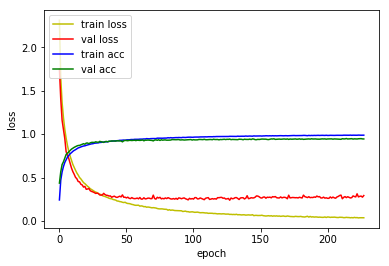

4815/4815 [==============================] - 1s 250us/sample - loss: 0.3043 - acc: 0.9180
Loss: 0.3043327937430682 Accuracy: 0.9179647

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0759 - acc: 0.3265
Epoch 00001: val_loss improved from inf to 1.38257, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_7_conv_checkpoint/001-1.3826.hdf5
36805/36805 [==============================] - 16s 434us/sample - loss: 2.0746 - acc: 0.3269 - val_loss: 1.3826 - val_acc: 0.5656
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2870 - acc: 0.5867
Epoch 00002: val_loss improved from 1.38257 to 0.97218, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_7_conv_checkpoint/002-0.9722.hdf5
36805/36805 [==============================] - 12s 329us/sample - loss: 1.2872 - acc: 0.5866 - val_loss: 0.9722 - val_acc: 0.7004
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s 

Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2336 - acc: 0.9217
Epoch 00024: val_loss improved from 0.23438 to 0.23147, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_7_conv_checkpoint/024-0.2315.hdf5
36805/36805 [==============================] - 12s 331us/sample - loss: 0.2335 - acc: 0.9217 - val_loss: 0.2315 - val_acc: 0.9306
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9248
Epoch 00025: val_loss did not improve from 0.23147
36805/36805 [==============================] - 12s 327us/sample - loss: 0.2264 - acc: 0.9248 - val_loss: 0.2354 - val_acc: 0.9304
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2188 - acc: 0.9264
Epoch 00026: val_loss did not improve from 0.23147
36805/36805 [==============================] - 12s 323us/sample - loss: 0.2188 - acc: 0.9264 - val_loss: 0.2368 - val_acc: 0.9266
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s

Epoch 81/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9811
Epoch 00081: val_loss did not improve from 0.19487
36805/36805 [==============================] - 12s 323us/sample - loss: 0.0545 - acc: 0.9811 - val_loss: 0.2135 - val_acc: 0.9504
Epoch 82/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9827
Epoch 00082: val_loss did not improve from 0.19487
36805/36805 [==============================] - 12s 326us/sample - loss: 0.0491 - acc: 0.9827 - val_loss: 0.2235 - val_acc: 0.9483
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9834
Epoch 00083: val_loss did not improve from 0.19487
36805/36805 [==============================] - 12s 324us/sample - loss: 0.0492 - acc: 0.9834 - val_loss: 0.2414 - val_acc: 0.9478
Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9838
Epoch 00084: val_loss did not improve from 0.19487
36805/36805 [=====

Epoch 111/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9892
Epoch 00111: val_loss did not improve from 0.19487
36805/36805 [==============================] - 12s 323us/sample - loss: 0.0313 - acc: 0.9892 - val_loss: 0.2515 - val_acc: 0.9469
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9894
Epoch 00112: val_loss did not improve from 0.19487
36805/36805 [==============================] - 12s 322us/sample - loss: 0.0316 - acc: 0.9894 - val_loss: 0.2656 - val_acc: 0.9448
Epoch 113/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9882
Epoch 00113: val_loss did not improve from 0.19487
36805/36805 [==============================] - 12s 324us/sample - loss: 0.0356 - acc: 0.9882 - val_loss: 0.2209 - val_acc: 0.9509
Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9900
Epoch 00114: val_loss did not improve from 0.19487
36805/36805 [=

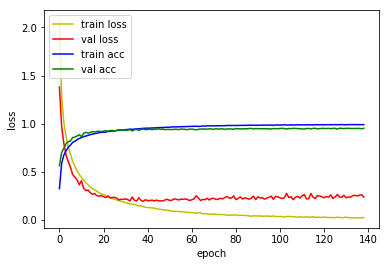

4815/4815 [==============================] - 1s 264us/sample - loss: 0.2636 - acc: 0.9196
Loss: 0.26358092670500094 Accuracy: 0.9196262

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.8025 - acc: 0.4125
Epoch 00001: val_loss improved from inf to 1.00706, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_8_conv_checkpoint/001-1.0071.hdf5
36805/36805 [==============================] - 20s 531us/sample - loss: 1.7998 - acc: 0.4134 - val_loss: 1.0071 - val_acc: 0.6765
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9711 - acc: 0.6847
Epoch 00002: val_loss improved from 1.00706 to 0.70624, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_8_conv_checkpoint/002-0.7062.hdf5
36805/36805 [==============================] - 14s 386us/sample - loss: 0.9715 - acc: 0.6847 - val_loss: 0.7062 - val_acc: 0.7673
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9649
Epoch 00024: val_loss did not improve from 0.19702
36805/36805 [==============================] - 15s 399us/sample - loss: 0.1023 - acc: 0.9650 - val_loss: 0.2064 - val_acc: 0.9371
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9663
Epoch 00025: val_loss did not improve from 0.19702
36805/36805 [==============================] - 15s 397us/sample - loss: 0.0999 - acc: 0.9662 - val_loss: 0.2224 - val_acc: 0.9348
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9699
Epoch 00026: val_loss did not improve from 0.19702
36805/36805 [==============================] - 15s 401us/sample - loss: 0.0879 - acc: 0.9699 - val_loss: 0.2210 - val_acc: 0.9369
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9701
Epoch 00027: val_loss did not improve from 0.19702
36805/36805 [=====

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9917
Epoch 00054: val_loss did not improve from 0.19702
36805/36805 [==============================] - 14s 392us/sample - loss: 0.0261 - acc: 0.9917 - val_loss: 0.2737 - val_acc: 0.9467
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9923
Epoch 00055: val_loss did not improve from 0.19702
36805/36805 [==============================] - 15s 396us/sample - loss: 0.0246 - acc: 0.9923 - val_loss: 0.2932 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9920
Epoch 00056: val_loss did not improve from 0.19702
36805/36805 [==============================] - 14s 394us/sample - loss: 0.0243 - acc: 0.9920 - val_loss: 0.2766 - val_acc: 0.9455
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9920
Epoch 00057: val_loss did not improve from 0.19702
36805/36805 [=====

Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9956- ETA: 1s - loss: 0.014
Epoch 00084: val_loss did not improve from 0.19702
36805/36805 [==============================] - 14s 394us/sample - loss: 0.0144 - acc: 0.9955 - val_loss: 0.3022 - val_acc: 0.9499
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9952
Epoch 00085: val_loss did not improve from 0.19702
36805/36805 [==============================] - 15s 395us/sample - loss: 0.0145 - acc: 0.9952 - val_loss: 0.3298 - val_acc: 0.9464
Epoch 86/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9942
Epoch 00086: val_loss did not improve from 0.19702
36805/36805 [==============================] - 14s 392us/sample - loss: 0.0179 - acc: 0.9942 - val_loss: 0.3529 - val_acc: 0.9418
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9957
Epoch 00087: val_loss did not improve from 0.1

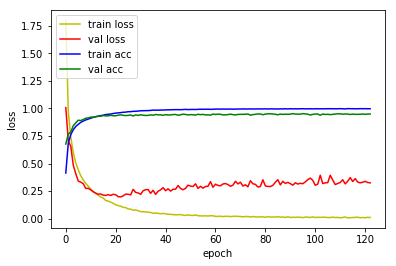

4815/4815 [==============================] - 2s 313us/sample - loss: 0.2944 - acc: 0.9132
Loss: 0.2944057830892743 Accuracy: 0.913188



In [10]:
for i in range(1, 9):
    base = '1D_CNN_only_conv_conv_5_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_conv_5_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_conv_5_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_only_conv_conv_5_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
activation_36 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 42656)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 42656)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                682512    
Total params: 682,560
Trainable params: 682,560
Non-trainable params: 0
_____________________________

4815/4815 [==============================] - 1s 303us/sample - loss: 0.5174 - acc: 0.8492
Loss: 0.5174186083015252 Accuracy: 0.84922117

1D_CNN_only_conv_conv_5_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
activation_51 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
activation_52 (Activation)   (None, 5328, 16)          0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (N

4815/4815 [==============================] - 2s 366us/sample - loss: 0.2944 - acc: 0.9132
Loss: 0.2944057830892743 Accuracy: 0.913188
